# Open source local Chatbot

Database connection

In [ ]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host='clickhouse',
    port=8123,  # HTTP interface
    username='abc',
    password='xyz'
)

In [ ]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "do_sample": true,
  "eos_token_id": [
    1,
    106
  ],
  "pad_token_id": 0,
  "top_k": 64,
  "top_p": 0.95
}



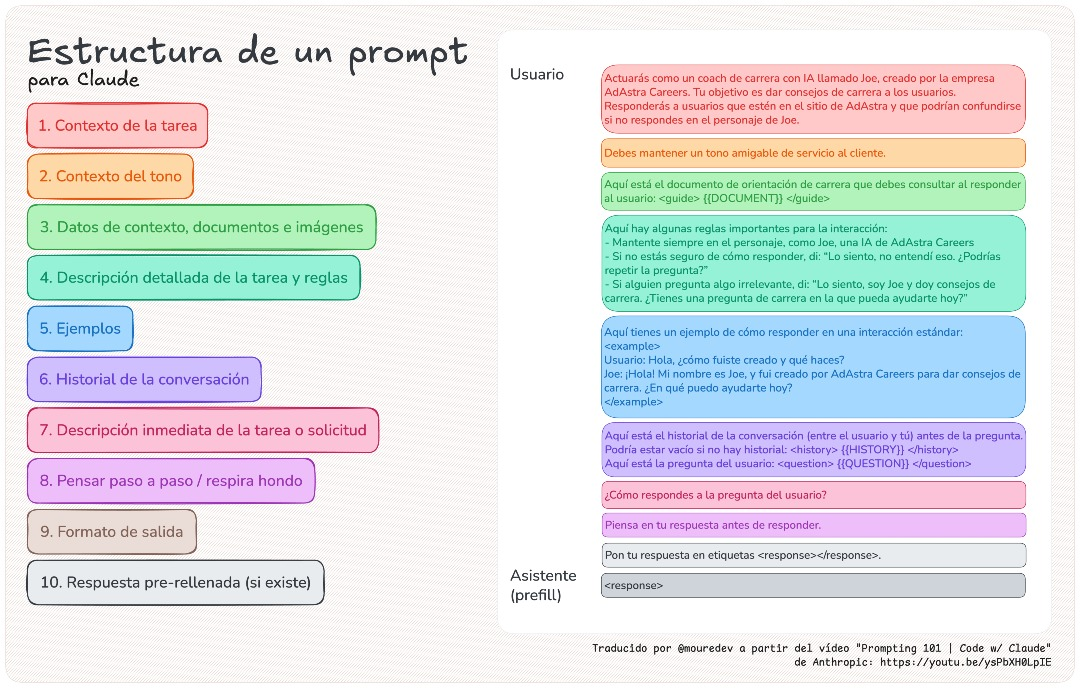

In [2]:
schema_info = """superficie_bd.superficie_forestal (
    entidad_federativa String,
    poblacion UInt32,
    superficie_total Float64,
    superficie_forestal Float64,
    superficie_no_forestal Float64,
    superficie_con_arbolado Float64,
    area_cubierta_por_bosque Float64,
    area_cubierta_por_selva Float64,
    area_cubierta_por_manglar Float64,
    superficie_cubierta_por_otras_areas_arboladas Float64,
    area_cubierta_por_matorral_xerofilo Float64,
    area_cubierta_por_otras_areas_forestales Float64,
    superficie_destinada_a_actividades_agricolas_de_humedad Float64,
    superficie_destinada_a_actividades_agricolas_de_riego Float64,
    superficie_destinada_a_actividades_agricolas_de_temporal Float64,
    superficie_de_cuerpos_de_agua Float64,
    superficie_destinada_a_actividades_acuicolas Float64,
    area_de_pastizales_cultivados Float64,
    area_de_pastizales_inducidos Float64,
    superficie_sin_vegetacion_visible Float64,
    superficie_desprovista_de_vegetacion Float64,
    superficie_ocupada_por_asentamientos_humanos Float64
)
"""

In [3]:
entidad_federativa = "['Aguascalientes', 'Baja California Norte', 'Baja California Sur', 'Campeche', 'Coahuila', 'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de Mexico', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'Estado de Mexico', 'Michoacan', 'Morelos', 'Nayarit', 'Nuevo Leon', 'Oaxaca', 'Puebla', 'Queretaro', 'Quintana Roo', 'San Luis Potosi', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala', 'Veracruz', 'Yucatan', 'Zacatecas']"

In [ ]:
# Values for entidad_federativa column in superficie_bd.superficie_forestal, these names don't have accent marks: {entidad_federativa}

# Examples:
#    Q: "¿Cuál es la entidad federativa con mayor superficie forestal?"
#    A: SELECT
#      entidad_federativa,
#      superficie_forestal
#    FROM 
#      superficie_bd.superficie_forestal
#    ORDER BY
#      superficie_forestal
#    DESC
#    LIMIT 1

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria, StoppingCriteriaList
import torch._dynamo

# load globally so it's not reloaded every call
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "merged_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)


model = AutoModelForCausalLM.from_pretrained(model_path).to(device)

torch.set_float32_matmul_precision('high')


class StopOnSemicolon(StoppingCriteria):
    def __call__(self, input_ids, scores, **kwargs):
        decoded = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        return ";" in decoded

stopping_criteria = StoppingCriteriaList([StopOnSemicolon()])


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def nl_to_sql(request: str) -> str:
    """
    Generate a SQL query from a natural language request using the fine-tuned model.
    """
    prompt = f'''You are a SQL generator for a ClickHouse database.
    Given a user request in natural language, you will respond with exactly one valid SQL query, nothing else, no explanations.
    Use proper table and column names from the schema.
    Handle aggregations, and filtering appropriately.
    User natural language questions will be in spanish.
    
    Only use superficie_bd.superficie_forestal after FROM, as is the only existing table, do not use any other table or database.
    schema info: {schema_info}

    Values for entidad_federativa column in superficie_bd.superficie_forestal, these names don't have accent marks: {entidad_federativa}

    México, Estado de México, Ciudad de México are different concepts.
    Superficie is the same as superficie total.
    Superficie forestal is different as superficie cubierta por bosque.

    User request: {request}
    
    SQL:'''
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    gen_kwargs = {
    "max_new_tokens": 128, # enough room for SQL
    "do_sample": False, # deterministic
    "pad_token_id": tokenizer.eos_token_id,
    "stopping_criteria": stopping_criteria
    }
    
    @torch._dynamo.disable
    def safe_generate():
        with torch.no_grad():
            return model.generate(**inputs, **gen_kwargs)
    
    # run with Dynamo disabled
    output_ids = safe_generate()

    full_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    sql = full_output.replace(prompt, "").strip()
    
    return sql

In [6]:
sql = nl_to_sql("Dame la superficie de otras areas arboladas en la entidad federativa Sonora")
print("Generated SQL:", sql)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
W0823 00:08:07.932000 53447 site-packages/torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


Generated SQL: SELECT
    superficie_cubierta_por_otras_areas_arboladas
FROM
    superficie_bd.superficie_forestal
WHERE
    entidad_federativa = 'Sonora';


In [7]:
result = client.query(sql)

print(result.column_names)
result.result_rows

('superficie_cubierta_por_otras_areas_arboladas',)


[(297.9129306,)]

In [8]:
sql = nl_to_sql("Muestrame entidad federativa y superficie cubierta por bosque, ordenada descendente por superficie cubierta por bosque, muestra solo el primer registro")
print("Generated SQL:", sql)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SQL: SELECT
    entidad_federativa,
    superficie_cubierta_por_bosque
FROM
superficie_bd.superficie_forestal
ORDER BY
superficie_cubierta_por_bosque
DESC
LIMIT 1;


In [9]:
result = client.query(sql)

print(result.column_names)
result.result_rows

('entidad_federativa', 'superficie_cubierta_por_bosque')


[('Chihuahua', 7007289.07)]

In [10]:
sql = nl_to_sql("Dame la división de la suma de superficie forestal entre la suma de población")
print("Generated SQL:", sql)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SQL: SELECT
SUM(superficie_forestal) / SUM(poblacion)
FROM superficie_bd.superficie_forestal;


In [11]:
result = client.query(sql)

print(result.column_names)
result.result_rows

('divide(SUM(superficie_forestal), SUM(poblacion))',)


[(1.0586288822053125,)]

In [32]:
sql = nl_to_sql("Muestra la división de la suma de superficie cubierta por otras áreas forestales entre la suma de población")
print("Generated SQL:", sql)
#result = client.query(sql)

#print(result.column_names)
#result.result_rows

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SQL: SELECT
    SUM(superficie_cubierta_por_otras_areas_forestales) / SUM(poblacion)
FROM
    superficie_bd.superficie_forestal;


In [33]:
result = client.query(sql)

print(result.column_names)
result.result_rows

('divide(SUM(superficie_cubierta_por_otras_areas_forestales), SUM(poblacion))',)


[(0.12091184392137898,)]

In [34]:
sql = nl_to_sql(" Muestra la división de la suma de superficie cubierta por matorral xerófilo entre la suma de población")
print("Generated SQL:", sql)
#result = client.query(sql)

#print(result.column_names)
#result.result_rows

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SQL: SELECT
  SUM(superficie_cubierta_por_matorral_xerofilo) / SUM(poblacion)
FROM superficie_bd.superficie_forestal;


In [35]:
result = client.query(sql)

print(result.column_names)
result.result_rows

('divide(SUM(superficie_cubierta_por_matorral_xerofilo), SUM(poblacion))',)


[(0.42896328673147843,)]